## Section 1 - Import Libraries

In [1]:
# Section 1: Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from google.colab import files
import io

## Section 2 - Import Data Set

In [2]:
# Section 2: Import Data Set

# Data loading function
def load_data_from_upload():
  uploaded = files.upload()
  for file_name in uploaded.keys():
    print(f"File uploaded: {file_name}")
    if file_name.endswith(".csv"):
      df = pd.read_csv(io.BytesIO(uploaded[file_name]))
      print(f"Loaded CSV file with shape {df.shape}")
      return df
    elif file_name.endswith(".json"):
      raw_data = json.load(io.BytesIO(uploaded[file_name]))
      records = []
      for frame in raw_data:
        frame_id = frame["frame_id"]
        for obj in frame["objects"]:
          records.append({
            "frame_id": frame_id,
            "object_name": obj["object_name"],
            "x_min": obj["bounding_box"][0],
            "y_min": obj["bounding_box"][1],
            "x_max": obj["bounding_box"][2],
            "y_max": obj["bounding_box"][3],
            "confidence": obj.get("confidence", None),
            "object_category": obj.get("category", None)
          })
      df = pd.DataFrame(records)
      print(f"Loaded JSON file with shape {df.shape}")
      return df
    else:
        raise ValueError("Unsupported file format. Please upload a .csv or .json file.")

In [3]:
df = load_data_from_upload()

Saving object_annotations_expanded.csv to object_annotations_expanded (1).csv
File uploaded: object_annotations_expanded (1).csv
Loaded CSV file with shape (154, 10)


## Section 3 - Schema Validation

In [4]:
# Section 3: Schema Validation

def validate_schema(df, expected_columns):
  actual_columns = set(df.columns.str.lower())
  expected_set = set(expected_columns)

  missing_columns = list(expected_set - actual_columns)
  unexpected_columns = list(actual_columns - expected_set)

  missing_summary = df.isnull().sum()
  dtype_summary = df.dtypes

  print("Schema Validation Report")
  print("--------------------------------------------------")
  print(f"Total Columns Present: {len(df.columns)}")
  print(f"Total Rows: {df.shape[0]}\n")

  if missing_columns:
    print(f"Missing Columns: {missing_columns}")
  else:
    print("All expected columns are present.")

  if unexpected_columns:
    print(f"Unexpected Columns: {unexpected_columns}")
  else:
    print("No unexpected columns.")

  print("\nMissing Values:")
  print(missing_summary[missing_summary > 0] if missing_summary.sum() > 0 else "✅ No missing values.")

  print("\nData Types:")
  print(dtype_summary)

  return {
    "missing_columns": missing_columns,
    "unexpected_columns": unexpected_columns,
    "missing_summary": missing_summary,
    "dtype_summary": dtype_summary
  }

In [5]:
expected_columns = [
 'frame_id',
 'object_name',
 'object_category',
 'x_min',
 'y_min',
 'x_max',
 'y_max',
 'confidence',
 'frame_type',
 'interaction_score'
]

schema_report = validate_schema(df, expected_columns)

Schema Validation Report
--------------------------------------------------
Total Columns Present: 10
Total Rows: 154

All expected columns are present.
No unexpected columns.

Missing Values:
confidence    12
dtype: int64

Data Types:
frame_id              object
object_name           object
x_min                  int64
y_min                  int64
x_max                  int64
y_max                  int64
confidence           float64
object_category       object
frame_type            object
interaction_score    float64
dtype: object


## Section 4 - Data Cleanup

In [6]:
# Section 4: Data Cleanup

# Expanded canonical label mapping, including typo corrections
label_reference = {
    "person": "person",
    "laptop": "laptop",
    "laptp": "laptop",            # typo fix
    "whiteboard": "whiteboard",
    "whitebored": "whiteboard",   # typo fix
    "smartphone": "smartphone",
    "SmartPhone".lower(): "smartphone",
    "coffee_mug": "coffee_mug",
    "mug_": "coffee_mug",         # typo fix
    "tablet": "tablet",
    "desk": "desk",
    "projector_screen": "projector_screen"
}

# 1. Normalize column names
df.columns = [col.strip().lower().replace(" ", "_") for col in df.columns]

# 2. Normalize and correct object_name
df["object_name"] = (
    df["object_name"]
    .astype(str)
    .str.strip()
    .str.lower()
    .map(label_reference)
    .fillna(df["object_name"].str.strip().str.lower().replace(" ", "_"))
)

# 3. Normalize object_category (if present)
if "object_category" in df.columns:
    df["object_category"] = (
        df["object_category"]
        .astype(str)
        .str.strip()
        .str.lower()
        .str.replace(" ", "_")
    )

# 4. Handle missing confidence
if "confidence" in df.columns:
    missing_count = df["confidence"].isna().sum()
    if missing_count:
        median_conf = df["confidence"].median()
        print(f"Filling {missing_count} missing confidence values with median: {median_conf:.2f}")
        df["confidence"] = df["confidence"].fillna(median_conf)

# Preview the cleaned dataset
df.head()

Filling 12 missing confidence values with median: 0.69


,frame_id,object_name,x_min,y_min,x_max,y_max,confidence,object_category,frame_type,interaction_score
0,frame_001,whiteboard,254,81,307,174,0.76,collaboration_tools,branch_1,0.24
1,frame_001,projector_screen,28,115,128,174,0.74,collaboration_tools,branch_1,0.14
2,frame_001,whiteboard,277,220,387,350,0.46,collaboration_tools,branch_1,0.72
3,frame_001,coffee_mug,238,92,347,235,0.79,props,branch_1,0.67
4,frame_001,smartphone,235,275,310,333,0.86,electronics,branch_1,0.48


## Section 5 - Initial EDA

Summary statistics for numeric columns:


,x_min,y_min,x_max,y_max,confidence,interaction_score
count,154.000000,154.000000,154.000000,154.000000,154.000000,154.000000
mean,198.396104,154.103896,297.474026,256.344156,0.697273,0.557338
std,115.493509,87.496343,116.645724,89.390630,0.158569,0.246760
min,3.000000,0.000000,76.000000,77.000000,0.400000,0.100000
25%,106.000000,77.250000,203.250000,186.000000,0.580000,0.360000
50%,196.000000,157.500000,297.000000,262.000000,0.690000,0.540000
75%,297.250000,231.000000,392.250000,330.500000,0.820000,0.770000
max,399.000000,300.000000,514.000000,441.000000,0.990000,0.970000



Object frequency:


,count
object_name,
whiteboard,24
coffee_mug,24
smartphone,24
laptop,24
person,21
desk,14
tablet,13
projector_screen,10


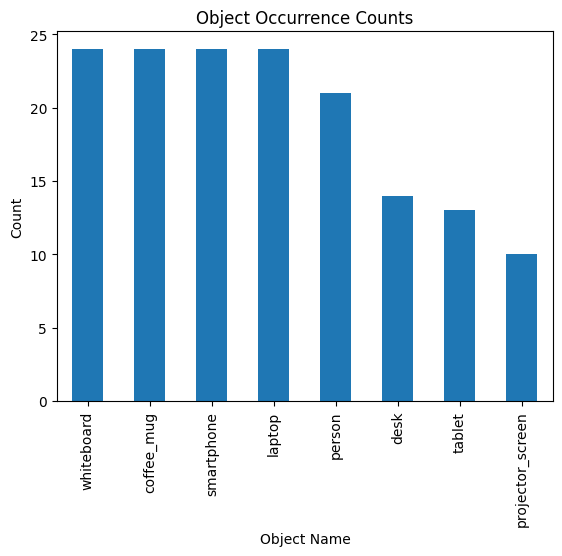

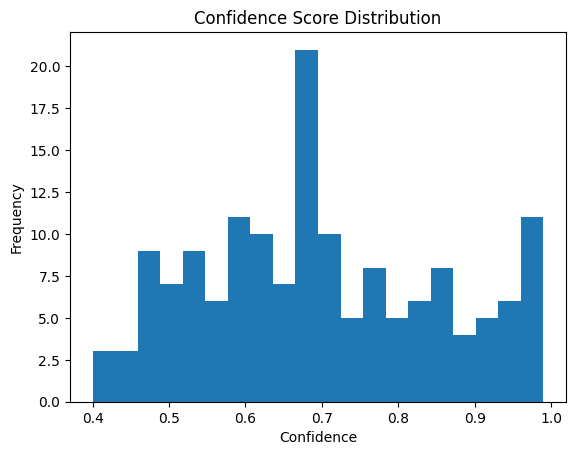


Missing values per column:


,0
frame_id,0
object_name,0
x_min,0
y_min,0
x_max,0
y_max,0
confidence,0
object_category,0
frame_type,0
interaction_score,0


In [7]:
# Section 5: Initial EDA

print("Summary statistics for numeric columns:")
display(df.describe())

# Object frequency
object_counts = df['object_name'].value_counts()
print("\nObject frequency:")
display(object_counts)

plt.figure()
object_counts.plot.bar()
plt.title('Object Occurrence Counts')
plt.xlabel('Object Name')
plt.ylabel('Count')
plt.show()

# Confidence score
plt.figure()
plt.hist(df['confidence'], bins=20)
plt.title('Confidence Score Distribution')
plt.xlabel('Confidence')
plt.ylabel('Frequency')
plt.show()

# Missing values check
print("\nMissing values per column:")
display(df.isnull().sum())

## Section 6 - Final Export

In [16]:
# Section 6: Final Export

from google.colab import files

# 1. Save cleaned DataFrame to a local CSV file in Colab workspace
local_filename = "cleaned_object_annotations.csv"
df.to_csv(local_filename, index=False)
print(f"✅ Cleaned dataset written to local file: {local_filename}")

# 2. Trigger browser download to your default Downloads folder
files.download(local_filename)

✅ Cleaned dataset written to local file: cleaned_object_annotations.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>